In [1]:
import pandas as pd
import disaggregator as dis
from disaggregator import spatial, plot, temporal #, data, config
import matplotlib.pyplot as plt

Notice: <br>
The following two fields represent options to turn off warnings in the output (from [Stackoverflow](https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython)). This allows the evaluation of the results of the module by the end user without being distracted by red warnings that are not relevant to the evaluation. For development purposes the option to turn those warnings on still remains.

In [2]:
# this part only works when exporting the notebook as a html file
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [3]:
# global setting for the whole notebook, can be set to "action = 'once'" if the first warning should be shown
import warnings
warnings.filterwarnings('ignore')

# Area of applications

This notebook demonstrates the functionality of the module to disaggregate the energy consumption over typical areas of application. The chosen applications represent the commonly used separation of final energy usage as in [[BMU](https://www.bmu.de/fileadmin/Daten_BMU/Pools/Forschungsdatenbank/fkz_3712_12_102_energieeffizienzma%C3%9Fnahmen_bewertung_bf.pdf)] or [[AGEB](https://ag-energiebilanzen.de/8-0-Anwendungsbilanzen.html)].

The implementation of this disaggreation is mainly implemented trough a function for the spatial data and another function for the temporal data. This allows to view the level of detail that is wanted in each case.

# disaggregate the spatial data

The relevant function for spatial data is **spatial.disagg_applications()**. This function is based on *spatial.disagg_CTS_industry()* whose functionality gets demonstrated in *03_Demo_CTS_Industry_disaggregation*. 

The function yields a table with the consumption per branch ("WZ") and application ("AWB") for every district in germany.

In [4]:
ec_industry = spatial.disagg_applications(source = "power", sector = "industry", use_nuts3code = True)
ec_industry.head()

WZ             5                                                      \
AWB   Beleuchtung  IKT Klimakälte Prozesskälte Mechanische \nEnergie   
DEF01         0.0  0.0        0.0          0.0                   0.0   
DEF02         0.0  0.0        0.0          0.0                   0.0   
DEF03         0.0  0.0        0.0          0.0                   0.0   
DEF04         0.0  0.0        0.0          0.0                   0.0   
DEF05         0.0  0.0        0.0          0.0                   0.0   

WZ                                                6                ...  \
AWB   Prozesswärme Raumwärme Warmwasser  Beleuchtung          IKT  ...   
DEF01          0.0       0.0        0.0     0.000000     0.000000  ...   
DEF02          0.0       0.0        0.0     0.000000     0.000000  ...   
DEF03          0.0       0.0        0.0     0.000000     0.000000  ...   
DEF04          0.0       0.0        0.0     0.000000     0.000000  ...   
DEF05          0.0       0.0        0.0  2737.665436  2494.317397  ...   

WZ             32                       33                           \
AWB     Raumwärme  Warmwasser  Beleuchtung          IKT  Klimakälte   
DEF01   10.437518    6.958345    68.643652    89.694371   21.050720   
DEF02   23.551322   15.700881   389.771283   509.301144  119.529860   
DEF03  264.751652  176.501101   358.322745   468.208386  109.885642   
DEF04   29.974410   19.982940   153.430750   200.482846   47.052097   
DEF05    7.560510    5.040340  1798.581730  2350.146794  551.565064   

WZ                                                                            
AWB   Prozesskälte Mechanische \nEnergie Prozesswärme   Raumwärme Warmwasser  
DEF01     6.406741            455.793847    69.558900    5.491492   3.660995  
DEF02    36.378653           2588.081321   394.968234   31.181703  20.787802  
DEF03    33.443456           2379.263024   363.100381   28.665820  19.110546  
DEF04    14.320203           1018.780178   155.476493   12.274460   8.182973  
DEF05   167.867628          11942.582686  1822.562820  143.886538  95.924359  

[5 rows x 232 columns]

# spatial graphs

This data can be visualised via the *plot* module. Perhaps the easiest  way to get fast results is to group the data off all branches together and get the consumption per application and district

In [5]:
ec_industry_applications = ec_industry.groupby("AWB", axis = 1).sum()/1000
ec_industry_applications.head()

AWB,Beleuchtung,IKT,Klimakälte,Mechanische \nEnergie,Prozesskälte,Prozesswärme,Raumwärme,Warmwasser
DEF01,4.589563,4.894792,2.489023,69.136599,3.940820,9.667805,0.349218,0.232812
DEF02,12.356891,12.794354,4.789209,113.120029,4.862297,15.387444,0.937118,0.624745
DEF03,12.593906,14.656007,5.963181,145.656661,11.950131,27.162035,0.974467,0.649645
DEF04,6.812981,6.804998,2.767980,83.164448,3.494442,17.256733,0.514712,0.343141
DEF05,25.922834,26.993871,16.421573,603.813295,77.791211,195.410880,1.938415,1.292276


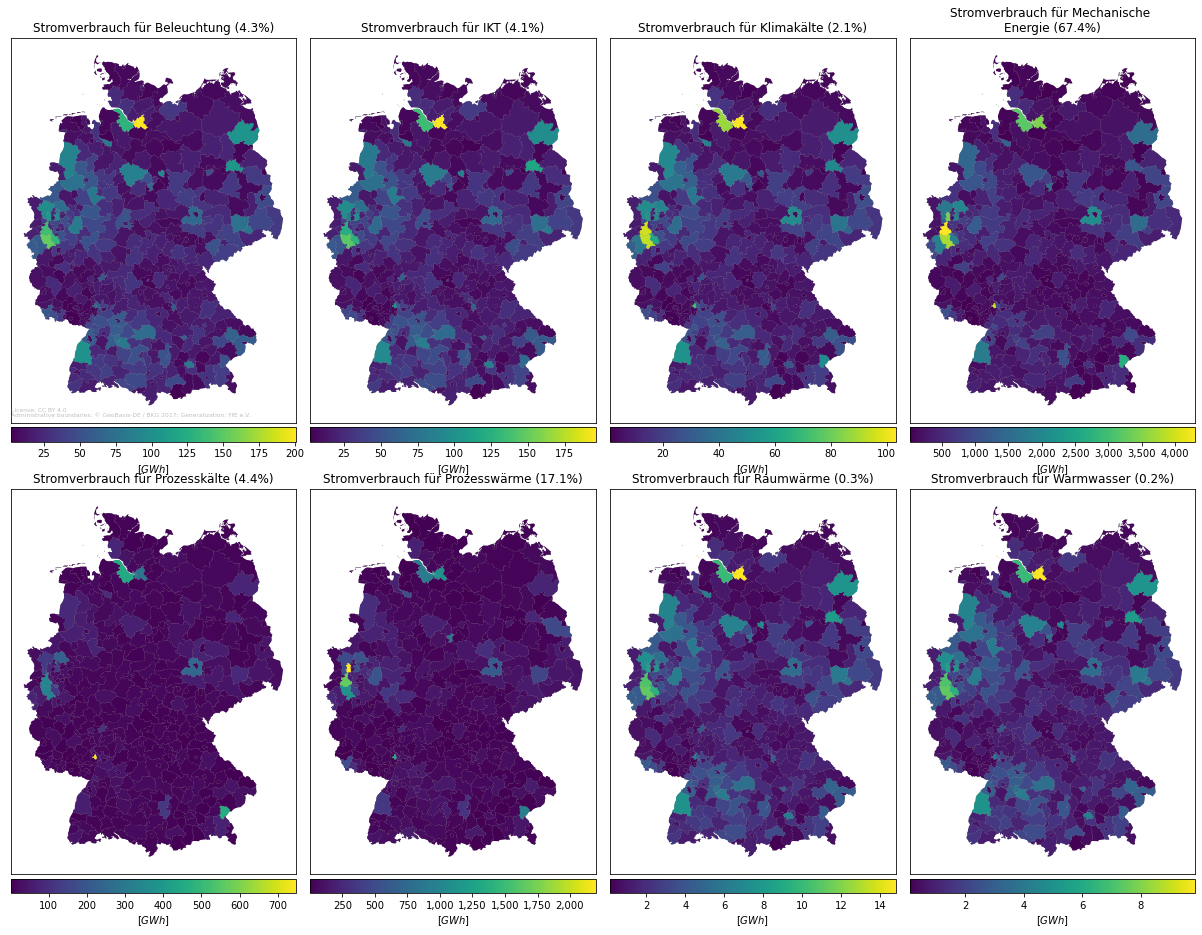

In [6]:
fig, ax = plot.choropleth_map(ec_industry_applications, relative=False, unit='GWh', axtitle='Stromverbrauch für', 
                              colorbar_each_subplot=True,  add_percentages=True)

Another option to visualise the data is to choose a specific branch and get the data for every application.

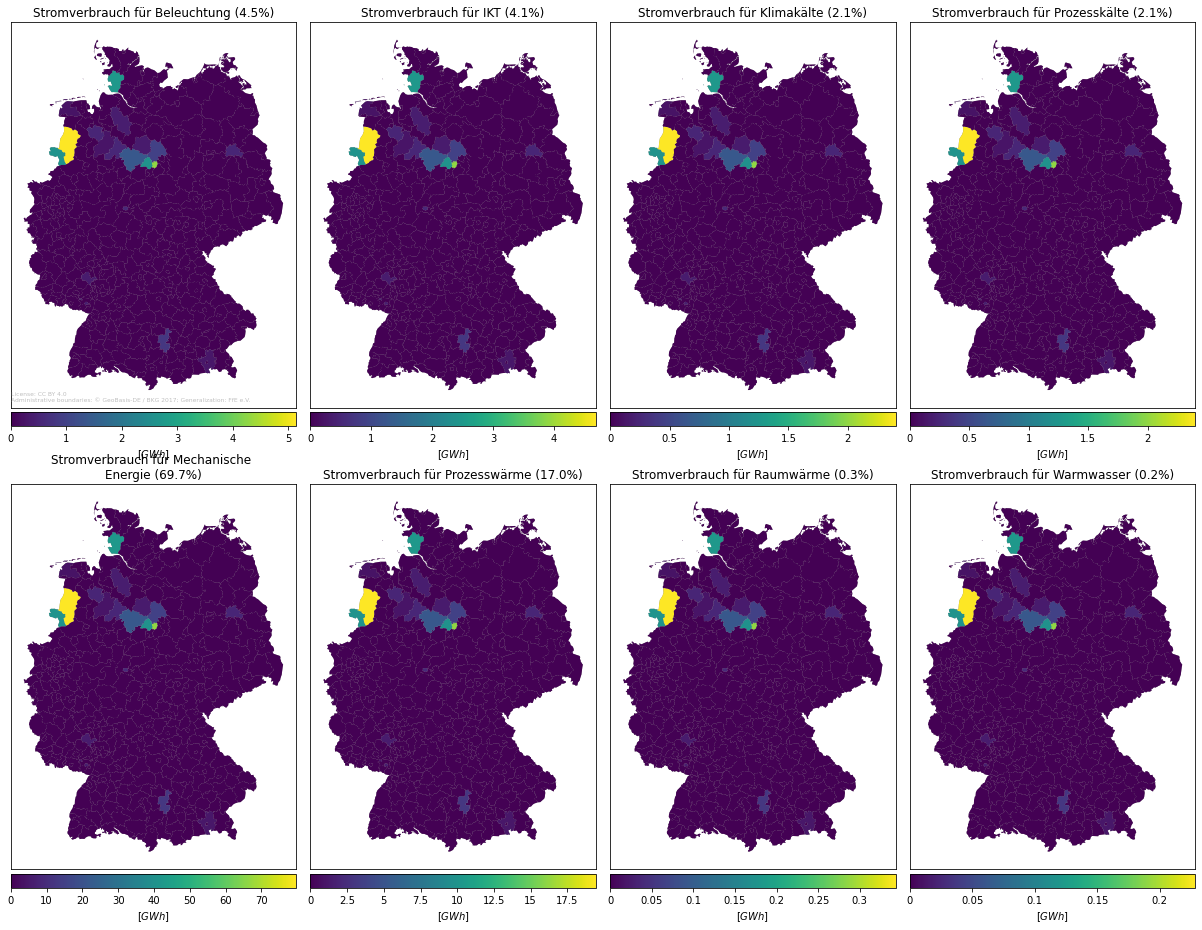

In [7]:
# mal colorbar_each_suplot = False bekommen, damit nicht jeder graph gleich aussieht
fig, ax = plot.choropleth_map(ec_industry[6]/1000, relative=False, unit='GWh', axtitle='Stromverbrauch für',
                              colorbar_each_subplot=True,  add_percentages=True)

# disaggregate the temporal data

The relevant function for temporal data is **temporal.disagg_temporal_applications()** which extends the functions demonstrated in the second part of  *03_Demo_CTS_industry_disaggregations.ipynb*. 

The function yields a time-indexed table with the consumption per district ("LK") and application ("AWB") in the simple case or the comsumption for every district ("LK") - branch ("WZ) - application ("AWB") combination in the detailed case.

The simple case of the disaggregation of consumption per LK and AWB is achieved by simply calling the function with the desired source and sector as arguments.

In [8]:
temp_power_CTS = temporal.disagg_temporal_applications("power", "CTS", use_nuts3code = True)

disaggregator.temporal: INFO     Working on state: SH.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: HH.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: NI.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: HB.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: NW.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggrega

In [9]:
temp_power_CTS.head()

LK                        DEF01                                    \
VW                  Beleuchtung       IKT Klimakälte Prozesskälte   
2015-01-01 00:00:00    0.997189  0.461888   0.058118     0.235532   
2015-01-01 00:15:00    1.047792  0.485327   0.061068     0.247485   
2015-01-01 00:30:00    1.019952  0.472432   0.059445     0.240909   
2015-01-01 00:45:00    0.995507  0.461109   0.058020     0.235135   
2015-01-01 01:00:00    0.977266  0.452660   0.056957     0.230827   

LK                                                                           \
VW                  Mechanische \nEnergie Prozesswärme Raumwärme Warmwasser   
2015-01-01 00:00:00              0.936012     0.149884  0.113178   0.107060   
2015-01-01 00:15:00              0.983510     0.157490  0.118921   0.112493   
2015-01-01 00:30:00              0.957378     0.153306  0.115761   0.109504   
2015-01-01 00:45:00              0.934433     0.149631  0.112987   0.106880   
2015-01-01 01:00:00              0.917311     0.146890  0.110917   0.104921   

LK                        DEF02            ...     DEG0L             \
VW                  Beleuchtung       IKT  ... Raumwärme Warmwasser   
2015-01-01 00:00:00    2.687099  1.244638  ...  0.087731   0.082988   
2015-01-01 00:15:00    2.872674  1.330594  ...  0.090114   0.085243   
2015-01-01 00:30:00    2.786839  1.290836  ...  0.088166   0.083401   
2015-01-01 00:45:00    2.713515  1.256873  ...  0.086549   0.081871   
2015-01-01 01:00:00    2.659803  1.231995  ...  0.085430   0.080812   

LK                        DEG0M                                    \
VW                  Beleuchtung       IKT Klimakälte Prozesskälte   
2015-01-01 00:00:00    0.699015  0.323777   0.040740     0.165105   
2015-01-01 00:15:00    0.719452  0.333243   0.041931     0.169932   
2015-01-01 00:30:00    0.704307  0.326228   0.041049     0.166355   
2015-01-01 00:45:00    0.691731  0.320403   0.040316     0.163384   
2015-01-01 01:00:00    0.683079  0.316395   0.039811     0.161341   

LK                                                                           
VW                  Mechanische \nEnergie Prozesswärme Raumwärme Warmwasser  
2015-01-01 00:00:00              0.656131     0.105067  0.079336   0.075048  
2015-01-01 00:15:00              0.675314     0.108139  0.081656   0.077242  
2015-01-01 00:30:00              0.661098     0.105862  0.079937   0.075616  
2015-01-01 00:45:00              0.649294     0.103972  0.078509   0.074266  
2015-01-01 01:00:00              0.641172     0.102671  0.077527   0.073337  

[5 rows x 3208 columns]

The further disaggregated timeseries, which also takes the branches into consideration can be calculated by setting *detailed = True*.

But in the case that we want to get the applications ("AWB") for every district ("LK") and branch ("WZ") we need to specify the branch(es) that we want to view. This is done for computational reason because the full data set gets very large.

The branch can be choosen by setting "*wz*" to an int or a list of branches according to the naming scheme of [WZ08](https://www.destatis.de/DE/Methoden/Klassifikationen/Gueter-Wirtschaftsklassifikationen/klassifikation-wz-2008.html)

In [10]:
temp_power_CTS_detailed = temporal.disagg_temporal_applications("power", "CTS", detailed = True, use_nuts3code = True, wz = [46,47])

disaggregator.temporal: INFO     Working on state: SH.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: HH.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: NI.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: HB.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggregator.temporal: INFO     Working on state: NW.
disaggregator.temporal: INFO     ... creating state-specific load-profiles
disaggregator.temporal: INFO     ... assigning load-profiles to WZs
disaggrega

In [11]:
temp_power_CTS_detailed.head()

LK                        DEF01                                    \
WZ                           46                                     
AWB                 Beleuchtung       IKT Klimakälte Prozesskälte   
2015-01-01 00:00:00    0.048201  0.021958   0.002678     0.011381   
2015-01-01 00:15:00    0.051719  0.023561   0.002873     0.012212   
2015-01-01 00:30:00    0.049919  0.022741   0.002773     0.011786   
2015-01-01 00:45:00    0.048201  0.021958   0.002678     0.011381   
2015-01-01 01:00:00    0.046646  0.021250   0.002591     0.011014   

LK                                                                           \
WZ                                                                            
AWB                 Mechanische \nEnergie Prozesswärme Raumwärme Warmwasser   
2015-01-01 00:00:00              0.033071     0.006427  0.004954   0.005222   
2015-01-01 00:15:00              0.035485     0.006896  0.005316   0.005603   
2015-01-01 00:30:00              0.034250     0.006656  0.005131   0.005408   
2015-01-01 00:45:00              0.033071     0.006427  0.004954   0.005222   
2015-01-01 01:00:00              0.032004     0.006219  0.004794   0.005053   

LK                                         ...     DEG0M             \
WZ                           47            ...        46              
AWB                 Beleuchtung       IKT  ... Raumwärme Warmwasser   
2015-01-01 00:00:00    0.189442  0.086302  ...  0.002230   0.002350   
2015-01-01 00:15:00    0.203273  0.092602  ...  0.002392   0.002522   
2015-01-01 00:30:00    0.196197  0.089378  ...  0.002309   0.002434   
2015-01-01 00:45:00    0.189442  0.086302  ...  0.002230   0.002350   
2015-01-01 01:00:00    0.183331  0.083518  ...  0.002158   0.002274   

LK                                                                 \
WZ                           47                                     
AWB                 Beleuchtung       IKT Klimakälte Prozesskälte   
2015-01-01 00:00:00    0.092256  0.042028   0.005125     0.021783   
2015-01-01 00:15:00    0.098991  0.045096   0.005499     0.023373   
2015-01-01 00:30:00    0.095545  0.043526   0.005308     0.022559   
2015-01-01 00:45:00    0.092256  0.042028   0.005125     0.021783   
2015-01-01 01:00:00    0.089280  0.040672   0.004960     0.021080   

LK                                                                           
WZ                                                                           
AWB                 Mechanische \nEnergie Prozesswärme Raumwärme Warmwasser  
2015-01-01 00:00:00              0.063298     0.012301  0.009482   0.009994  
2015-01-01 00:15:00              0.067919     0.013199  0.010174   0.010724  
2015-01-01 00:30:00              0.065554     0.012739  0.009820   0.010351  
2015-01-01 00:45:00              0.063298     0.012301  0.009482   0.009994  
2015-01-01 01:00:00              0.061256     0.011904  0.009176   0.009672  

[5 rows x 6416 columns]

# temporal graphs
There are multiple ways to visualise the temporal data sets

## 1. selection of a LK-(WZ)-VW combination

### 1.1. plotting via pyplot
The simplest option to plot the might be to simply call the *.plot()* function from a dataframe which uses the pyplot backend of pandas to visualise the data. This can be used to get a first overview of the underlying data.

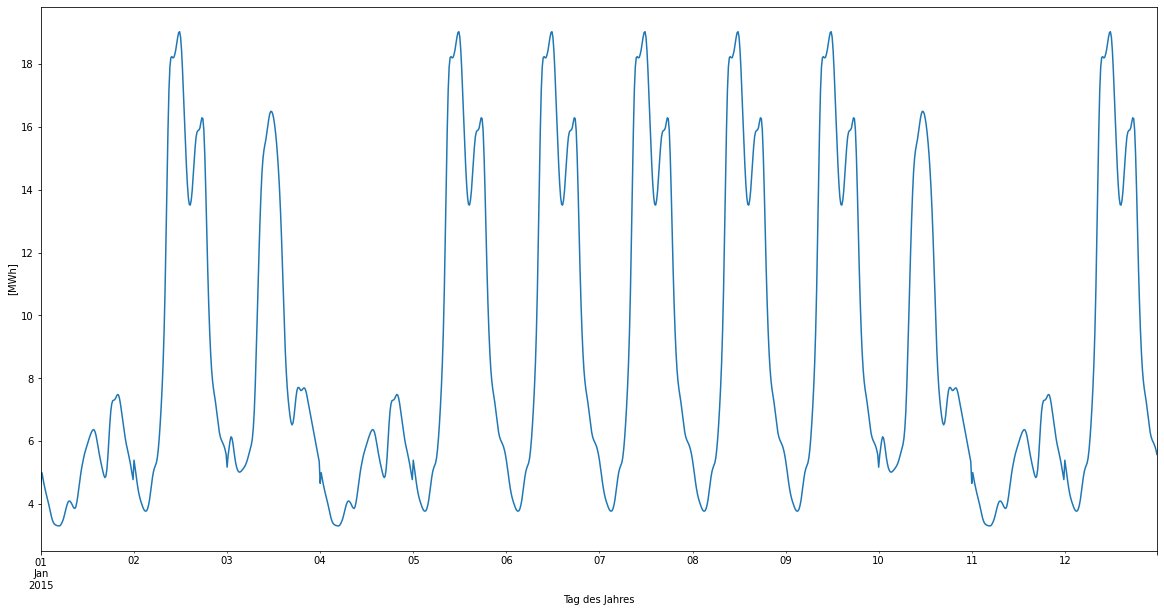

In [12]:
fig = temp_power_CTS_detailed["DE300", 47, "Beleuchtung"].head(1152).plot(figsize = (20, 10), ylabel = "[MWh]", xlabel = "Tag des Jahres")

### 1.2. using the heatmap funktion
A more elegant option is to call the *plot.heatmap_timeseries* function to get a heatmap of the same data.

Because the returned data has a resolution of 15 min and the function was the designed to interpret a hourly resolution the results of simply calling the function might be confusing.

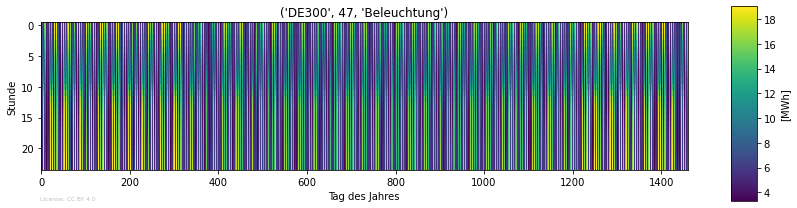

In [13]:
fig, ax = plot.heatmap_timeseries(temp_power_CTS_detailed["DE300", 47, "Beleuchtung"], clabel = "[MWh]")

To get a more pleasing visual we resample our data by aggregating the quarter hours into full hours.

In [14]:
power_CTS_hourly = temp_power_CTS_detailed.resample("h").sum()
power_CTS_hourly.head()

LK                        DEF01                                    \
WZ                           46                                     
AWB                 Beleuchtung       IKT Klimakälte Prozesskälte   
2015-01-01 00:00:00    0.198040  0.090218   0.011002     0.046759   
2015-01-01 01:00:00    0.178481  0.081308   0.009916     0.042141   
2015-01-01 02:00:00    0.156550  0.071317   0.008697     0.036963   
2015-01-01 03:00:00    0.140428  0.063973   0.007802     0.033157   
2015-01-01 04:00:00    0.137073  0.062444   0.007615     0.032364   

LK                                                                           \
WZ                                                                            
AWB                 Mechanische \nEnergie Prozesswärme Raumwärme Warmwasser   
2015-01-01 00:00:00              0.135877     0.026405  0.020354   0.021454   
2015-01-01 01:00:00              0.122458     0.023797  0.018344   0.019335   
2015-01-01 02:00:00              0.107410     0.020873  0.016090   0.016960   
2015-01-01 03:00:00              0.096349     0.018724  0.014433   0.015213   
2015-01-01 04:00:00              0.094047     0.018276  0.014088   0.014850   

LK                                         ...     DEG0M             \
WZ                           47            ...        46              
AWB                 Beleuchtung       IKT  ... Raumwärme Warmwasser   
2015-01-01 00:00:00    0.778354  0.354583  ...  0.009160   0.009656   
2015-01-01 01:00:00    0.701483  0.319565  ...  0.008256   0.008702   
2015-01-01 02:00:00    0.615286  0.280297  ...  0.007241   0.007633   
2015-01-01 03:00:00    0.551924  0.251432  ...  0.006496   0.006847   
2015-01-01 04:00:00    0.538737  0.245425  ...  0.006340   0.006683   

LK                                                                 \
WZ                           47                                     
AWB                 Beleuchtung       IKT Klimakälte Prozesskälte   
2015-01-01 00:00:00    0.379047  0.172677   0.021058     0.089497   
2015-01-01 01:00:00    0.341612  0.155623   0.018978     0.080658   
2015-01-01 02:00:00    0.299635  0.136500   0.016646     0.070747   
2015-01-01 03:00:00    0.268779  0.122444   0.014932     0.063462   
2015-01-01 04:00:00    0.262357  0.119518   0.014575     0.061945   

LK                                                                           
WZ                                                                           
AWB                 Mechanische \nEnergie Prozesswärme Raumwärme Warmwasser  
2015-01-01 00:00:00              0.260068     0.050540  0.038958   0.041063  
2015-01-01 01:00:00              0.234384     0.045548  0.035110   0.037008  
2015-01-01 02:00:00              0.205583     0.039951  0.030796   0.032460  
2015-01-01 03:00:00              0.184412     0.035837  0.027624   0.029118  
2015-01-01 04:00:00              0.180006     0.034981  0.026964   0.028422  

[5 rows x 6416 columns]

And then call the function again on the resampled data:

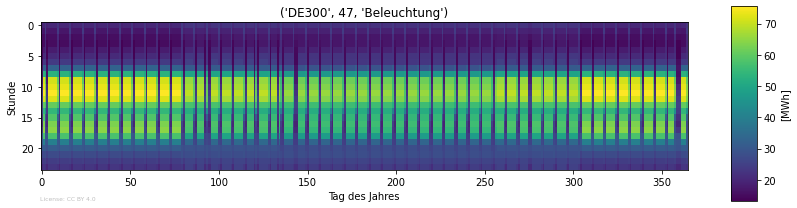

In [15]:
fig, ax = plot.heatmap_timeseries(power_CTS_hourly["DE300", 47, "Beleuchtung"], clabel = "[MWh]")

## 2. selection of a LK (-WZ combination)

### 2.1. via pyplot
To get a line graph of all applications within a district (and branch) call **temporal_plot_function()** from the *plot* modul.

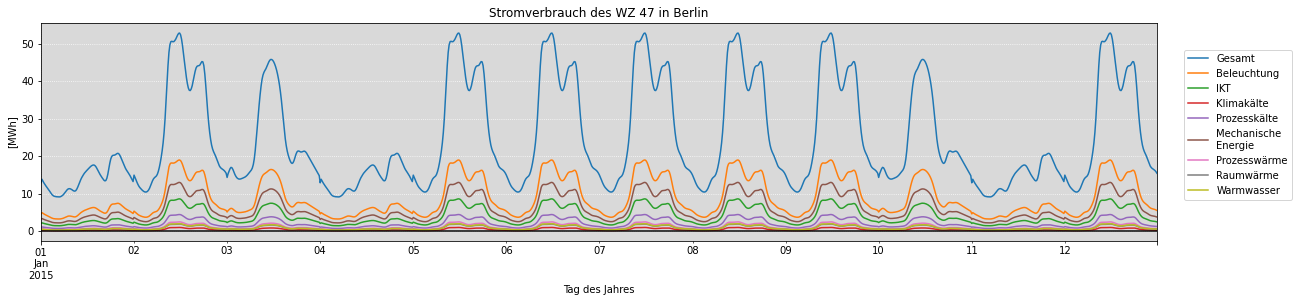

In [16]:
fig, ax = plot.temporal_plot_function(temp_power_CTS_detailed["DE300", 47].head(1152))
plot.set_ax_format(ax=ax, ylabel='[MWh]', xlabel='Tag des Jahres',
                   axtitle='Stromverbrauch des WZ 47 in Berlin')

### 2.2. using the heatmap function

When we call the *plot.heatmap_timeseries* function on a dataframe with a district-branch combination we get the heatmaps for all applications with the same scale:

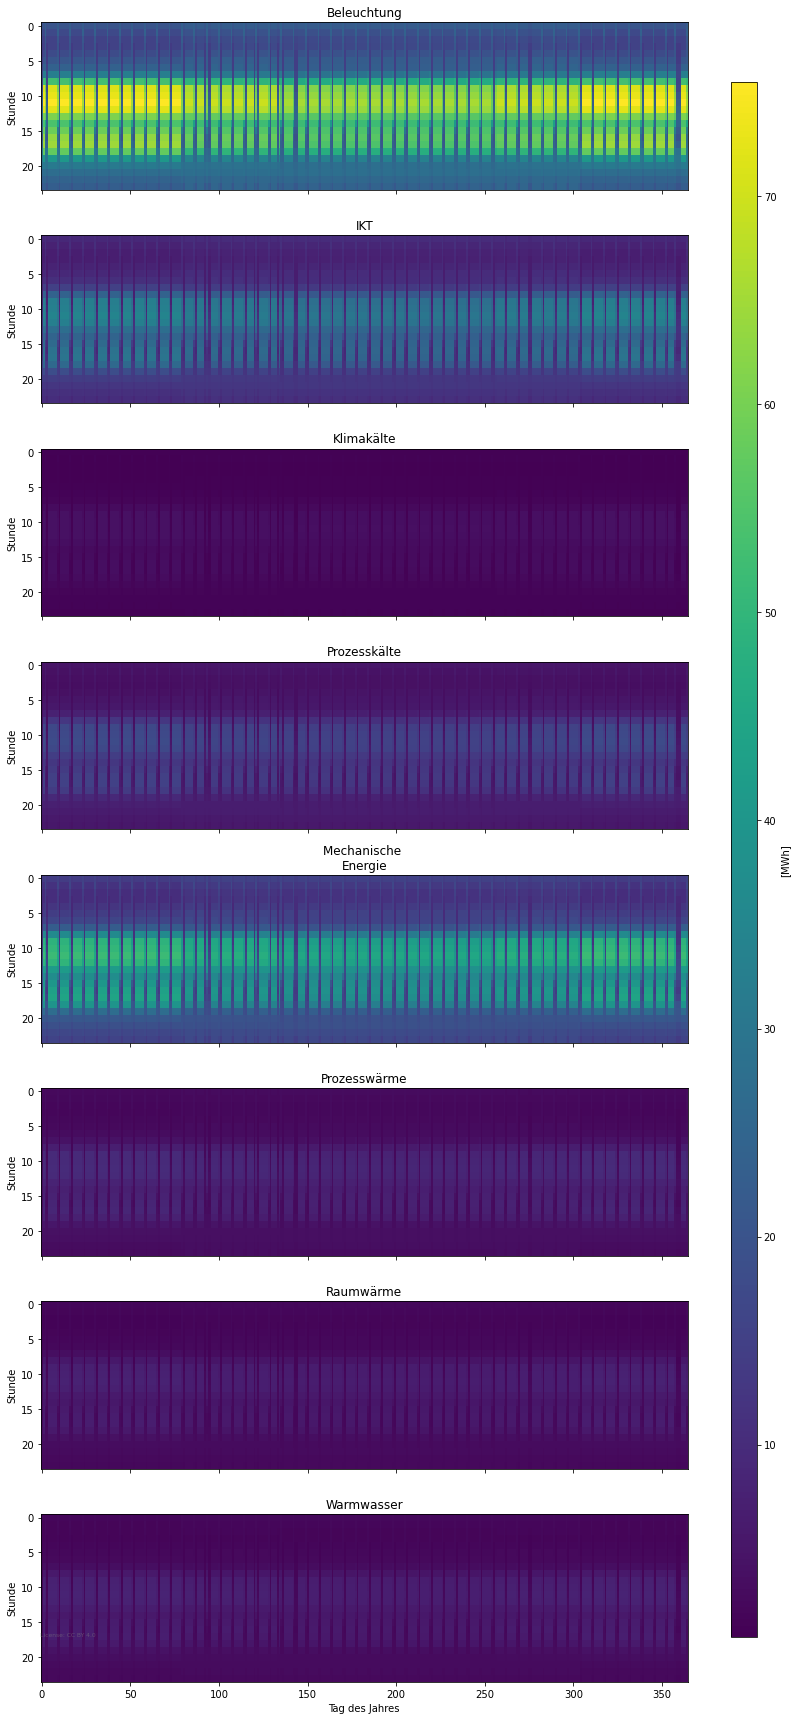

In [17]:
fig, ax = plot.heatmap_timeseries(power_CTS_hourly["DE300", 47], clabel = "[MWh]")